# Flopy Tutorial: Loading and modifying a Simple MODFLOW Model

In the previous tutorial, we created a simple MODFLOW-2005 model using FloPy. In this tutorial, we will explore how to load in the model input files that we created in the previous tutorial, and then modify some of the model inputs to see how the model responds to our changes.

First, let's complete our standard imports and set up the model name and path to the MODFLOW executable. We then simply use the `flopy.modflow.Modflow.load()` function to load in the model from the existing input files.

In [3]:
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import os

modelname = "simple_modflow_model"
original_ws = './simple_model'
modflow_path = '../../../modflow/mf2005'
m = flopy.modflow.Modflow.load(f'{original_ws}/{modelname}.nam', exe_name=modflow_path)
print(m)

MODFLOW 1 layer(s) 10 row(s) 10 column(s) 1 stress period(s)


# 1. Interacting with the loaded model

With our model in hand we now wish to modify some pieces of it. Let's start by examining the model structure and some of the key packages that we will want to modify.

In [4]:
# List all packages in the model
print("Available packages:")
print(m.get_package_list())
print("\n" + "="*60)

# Get model dimensions
print(f"\nModel dimensions:")
print(f"  Layers: {m.nlay}")
print(f"  Rows: {m.nrow}")
print(f"  Columns: {m.ncol}")
print(f"  Stress periods: {m.nper}")
print("\n" + "="*60)

# Access specific packages
dis = m.dis  # Discretization package
bas = m.bas6  # Basic package
lpf = m.lpf  # Layer Property Flow package
wel = m.wel  # Well package
rch = m.rch  # Recharge package

print(f"\nKey package information:")
print(f"  DIS - Discretization")
print(f"  BAS6 - Basic Package")
print(f"  LPF - Layer Property Flow")
print(f"  WEL - Well Package")
print(f"  RCH - Recharge Package")

Available packages:
['DIS', 'BAS6', 'LPF', 'OC', 'PCG']


Model dimensions:
  Layers: 1
  Rows: 10
  Columns: 10
  Stress periods: 1


Key package information:
  DIS - Discretization
  BAS6 - Basic Package
  LPF - Layer Property Flow
  WEL - Well Package
  RCH - Recharge Package


In [22]:
bas


    MODFLOW Basic Package Class.

    Parameters
    ----------
    model : model object
        The model object (of type :class:`flopy.modflow.mf.Modflow`) to which
        this package will be added.
    ibound : array of ints, optional
        The ibound array (the default is 1).
    strt : array of floats, optional
        An array of starting heads (the default is 1.0).
    ifrefm : bool, optional
        Indication if data should be read using free format (the default is
        True).
    ixsec : bool, optional
        Indication of whether model is cross sectional or not (the default is
        False).
    ichflg : bool, optional
        Flag indicating that flows between constant head cells should be
        calculated (the default is False).
    stoper : float
        percent discrepancy that is compared to the budget percent discrepancy
        continue when the solver convergence criteria are not met.  Execution
        will unless the budget percent discrepancy is greate

## 2. Inspecting Hydraulic Properties

Now let's look at the hydraulic conductivity. We can access the LPF package and print out the hydraulic conductivity array.

In [6]:
# Access hydraulic conductivity
hk = lpf.hk.array  # Horizontal hydraulic conductivity
hk2 = lpf.hk.array  # Horizontal hydraulic conductivity
vka = lpf.vka.array  # Vertical hydraulic conductivity (or anisotropy ratio)
ss = lpf.ss.array  # Specific storage
sy = lpf.sy.array  # Specific yield

print(f"Hydraulic conductivity (K) statistics:")
print(f"  Value: {np.mean(hk):.2f} m/d")
print(f"  Shape: {hk.shape}")
print(f"\nSpecific yield (Sy) statistics:")
print(f"  Mean: {np.mean(sy):.4f}")
print(f"  Shape: {sy.shape}")


Hydraulic conductivity (K) statistics:
  Value: 5.00 m/d
  Shape: (1, 10, 10)

Specific yield (Sy) statistics:
  Mean: 0.0000
  Shape: (1, 10, 10)


## 3. Creating a Modified Model

Now let's create a modified version of the model with different hydraulic properties. We'll create this in a **separate directory** to avoid overwriting the original model outputs.

The key principle: **Always write modified models to separate directories to preserve original results!**

In [7]:
m_original = flopy.modflow.Modflow.load(f'{original_ws}/{modelname}.nam', 
                                        exe_name=modflow_path, check=False)
    
# Set up the modified model in a SEPARATE directory
new_modelname = 'modified_model'
model_ws_modified = './modified_model'
os.makedirs(model_ws_modified, exist_ok=True)
m_mod = flopy.modflow.Modflow(modelname=new_modelname, 
                              exe_name=modflow_path,
                              model_ws=model_ws_modified)

# Copy discretization from original
dis = flopy.modflow.ModflowDis(m_mod, 
                                nlay=m.nlay, 
                                nrow=m.nrow, 
                                ncol=m.ncol,
                                delr=m.dis.delr.array, 
                                delc=m.dis.delc.array,
                                top=m.dis.top.array, 
                                botm=m.dis.botm.array,
                                nper=m.nper,
                                perlen=m.dis.perlen.array,
                                nstp=m.dis.nstp.array,
                                steady=m.dis.steady.array)

# Copy basic package
bas = flopy.modflow.ModflowBas(m_mod, 
                                ibound=m.bas6.ibound.array, 
                                strt=m.bas6.strt.array)

# Modify hydraulic conductivity to introduce heterogeneity
np.random.seed(42)  # For reproducibility
new_hk = np.random.normal(loc=10.0, scale=2.0, size=hk.shape)  # Mean 10 m/d, std 2 m/d
new_hk[new_hk < 0.1] = 0.1  # Ensure minimum K value

# Create LPF package with modified K
lpf_mod = flopy.modflow.ModflowLpf(m_mod, hk=new_hk, vka=1.0, sy=0.2, ss=1e-5, laytyp=1)

# Add solver
pcg = flopy.modflow.ModflowPcg(m_mod)

# Add Output Control - CRITICAL for saving outputs!
spd = {(0, 0): ['save head', 'save budget']}
oc = flopy.modflow.ModflowOc(m_mod, stress_period_data=spd, compact=True)

print(f"\nModified hydraulic conductivity:")
print(f"  Original K: {np.mean(hk):.2f} m/d (uniform)")
print(f"  Modified K: {np.mean(new_hk):.2f} ± {np.std(new_hk):.2f} m/d (heterogeneous)")
print(f"  Range: {np.min(new_hk):.2f} - {np.max(new_hk):.2f} m/d")


Modified hydraulic conductivity:
  Original K: 5.00 m/d (uniform)
  Modified K: 9.79 ± 1.81 m/d (heterogeneous)
  Range: 4.76 - 13.70 m/d


In [8]:
# Write and run the modified model
m_mod.write_input()
success, buff = m_mod.run_model(silent=True)
hds_path = f'{model_ws_modified}/{new_modelname}.hds'

## 4. Comparing Model Results

Now let's compare the hydraulic heads between the original and modified models to see how the heterogeneous hydraulic conductivity affected the groundwater flow system.

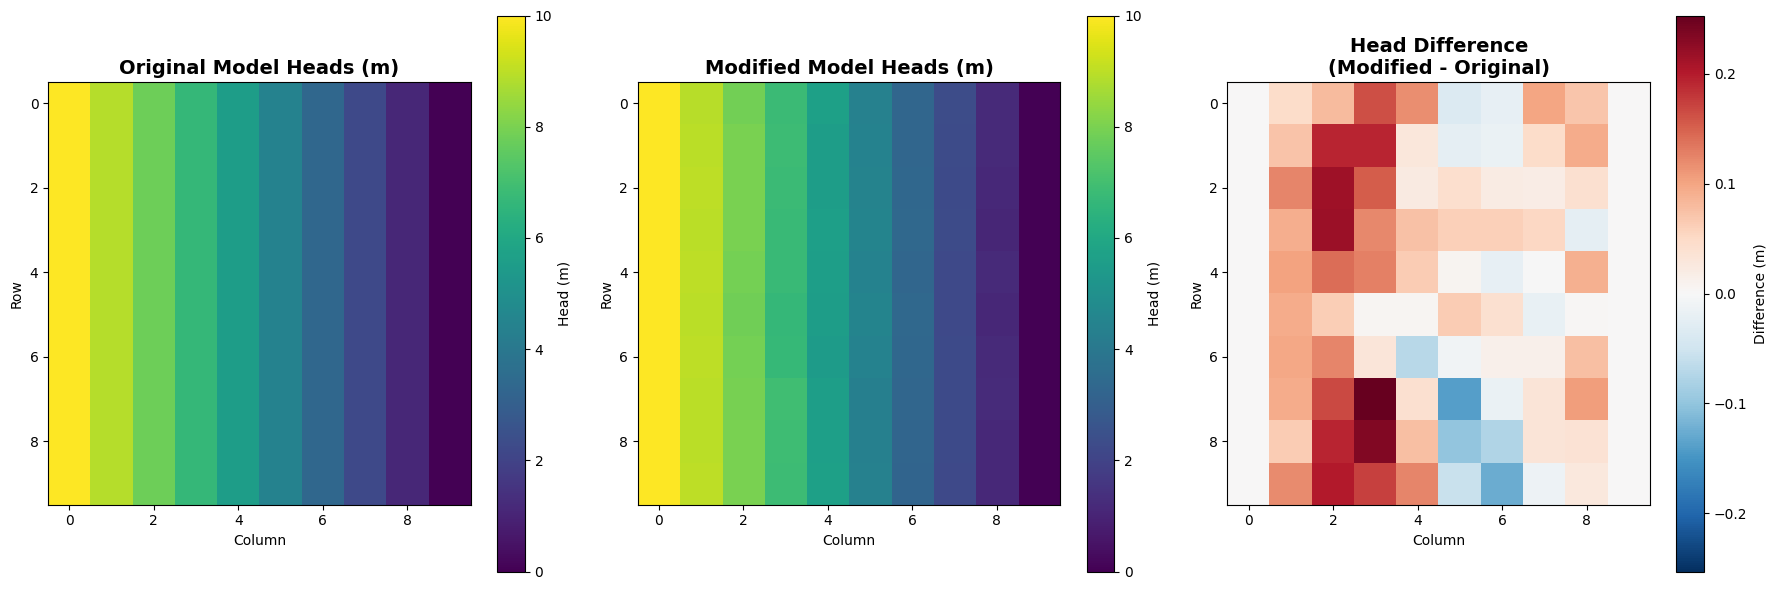

In [9]:
# Define file paths for both models
headfile_original = f'{original_ws}/{modelname}.hds'
headfile_modified = f'{model_ws_modified}/{new_modelname}.hds'

# Check if output files exist
if not os.path.exists(headfile_original):
    raise FileNotFoundError(f"Original model head file not found: {headfile_original}")

if not os.path.exists(headfile_modified):
    raise FileNotFoundError(f"Modified model head file not found: {headfile_modified}")

# Read heads from the original model
hds_original = flopy.utils.HeadFile(headfile_original)
head_original = hds_original.get_data()

# Read heads from the modified model
hds_modified = flopy.utils.HeadFile(headfile_modified)
head_modified = hds_modified.get_data()

# Calculate head difference and plot results
head_diff = head_modified - head_original
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
cmap = mp.cm.viridis

# Original heads
im1 = axes[0].imshow(head_original[0, :, :], cmap=cmap)
axes[0].set_title('Original Model Heads (m)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Column')
axes[0].set_ylabel('Row')
plt.colorbar(im1, ax=axes[0], orientation='vertical', label='Head (m)')

# Modified heads
im2 = axes[1].imshow(head_modified[0, :, :], cmap=cmap)
axes[1].set_title('Modified Model Heads (m)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Column')
axes[1].set_ylabel('Row')
plt.colorbar(im2, ax=axes[1], orientation='vertical', label='Head (m)')

# Head difference
im3 = axes[2].imshow(head_diff[0, :, :], cmap='RdBu_r', 
                     vmin=-np.max(np.abs(head_diff)), 
                     vmax=np.max(np.abs(head_diff)))
axes[2].set_title('Head Difference\n(Modified - Original)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Column')
axes[2].set_ylabel('Row')
plt.colorbar(im3, ax=axes[2], orientation='vertical', label='Difference (m)')

plt.tight_layout()
plt.show()

## 5. Hands-On Exercise: Create Your Own Model Modification

Now it's your turn! Try creating a different model modification. The modified model above used a random heterogeneous K field. You can try something different!

**Ideas for your experiment:**

1. **Structured K zones**: Create high and low K zones (e.g., a low-K barrier)
2. **Spatial gradients**: Make K increase from west to east
3. **Add boundary conditions**: Add wells or constant head boundaries
4. **Modify layer geometry**: Change elevations or thicknesses

### Template for Your Experiment:

Follow the same pattern as above:
1. Create a separate directory for your experiment
2. Load the original model to get the structure
3. Create a new model instance
4. Copy and modify packages
5. Run and compare with the original

**Try it in the cell below!**

In [10]:
m_original = flopy.modflow.Modflow.load(f'{original_ws}/{modelname}.nam', 
                                        exe_name=modflow_path, check=False)
    
# Set up the modified model in a SEPARATE directory
new_modelname2 = 'modified_model2'
model_ws_modified2 = './modified_model2'
os.makedirs(model_ws_modified2, exist_ok=True)
m_mod = flopy.modflow.Modflow(modelname=new_modelname2, 
                              exe_name=modflow_path,
                              model_ws=model_ws_modified2)

# Copy discretization from original
dis = flopy.modflow.ModflowDis(m_mod, 
                                nlay=m.nlay, 
                                nrow=m.nrow,
                                ncol=m.ncol,
                                delr=m.dis.delr.array, 
                                delc=m.dis.delc.array,
                                top=m.dis.top.array, 
                                botm=m.dis.botm.array,
                                nper=m.nper,
                                perlen=m.dis.perlen.array,
                                nstp=m.dis.nstp.array,
                                steady=m.dis.steady.array)

# Copy basic package
bas = flopy.modflow.ModflowBas(m_mod, 
                                ibound=m.bas6.ibound.array, 
                                strt=m.bas6.strt.array)

# Modify hydraulic conductivity to introduce heterogeneity
np.random.seed(42)  # For reproducibility
new_hk2 = np.random.normal(loc=2.0, scale=2.0, size=hk.shape)  # Mean 10 m/d, std 2 m/d
new_hk2[new_hk2 < 0.1] = 0.1  # Ensure minimum K value

# Create LPF package with modified K
lpf_mod = flopy.modflow.ModflowLpf(m_mod, hk=new_hk2, vka=.25, sy=0.8, ss=1e-5, laytyp=1)

# Add solver
pcg = flopy.modflow.ModflowPcg(m_mod)

# Add Output Control - CRITICAL for saving outputs!
spd = {(0, 0): ['save head', 'save budget']}
oc = flopy.modflow.ModflowOc(m_mod, stress_period_data=spd, compact=True)

print(f"\nModified hydraulic conductivity:")
print(f"  Original K: {np.mean(hk2):.2f} m/d (uniform)")
print(f"  Modified K: {np.mean(new_hk2):.2f} ± {np.std(new_hk2):.2f} m/d (heterogeneous)")
print(f"  Range: {np.min(new_hk2):.2f} - {np.max(new_hk2):.2f} m/d")


Modified hydraulic conductivity:
  Original K: 5.00 m/d (uniform)
  Modified K: 1.99 ± 1.50 m/d (heterogeneous)
  Range: 0.10 - 5.70 m/d


In [11]:
# Write and run the modified model
m_mod.write_input()
success, buff = m_mod.run_model(silent=True)
hds_path = f'{model_ws_modified2}/{new_modelname2}.hds'

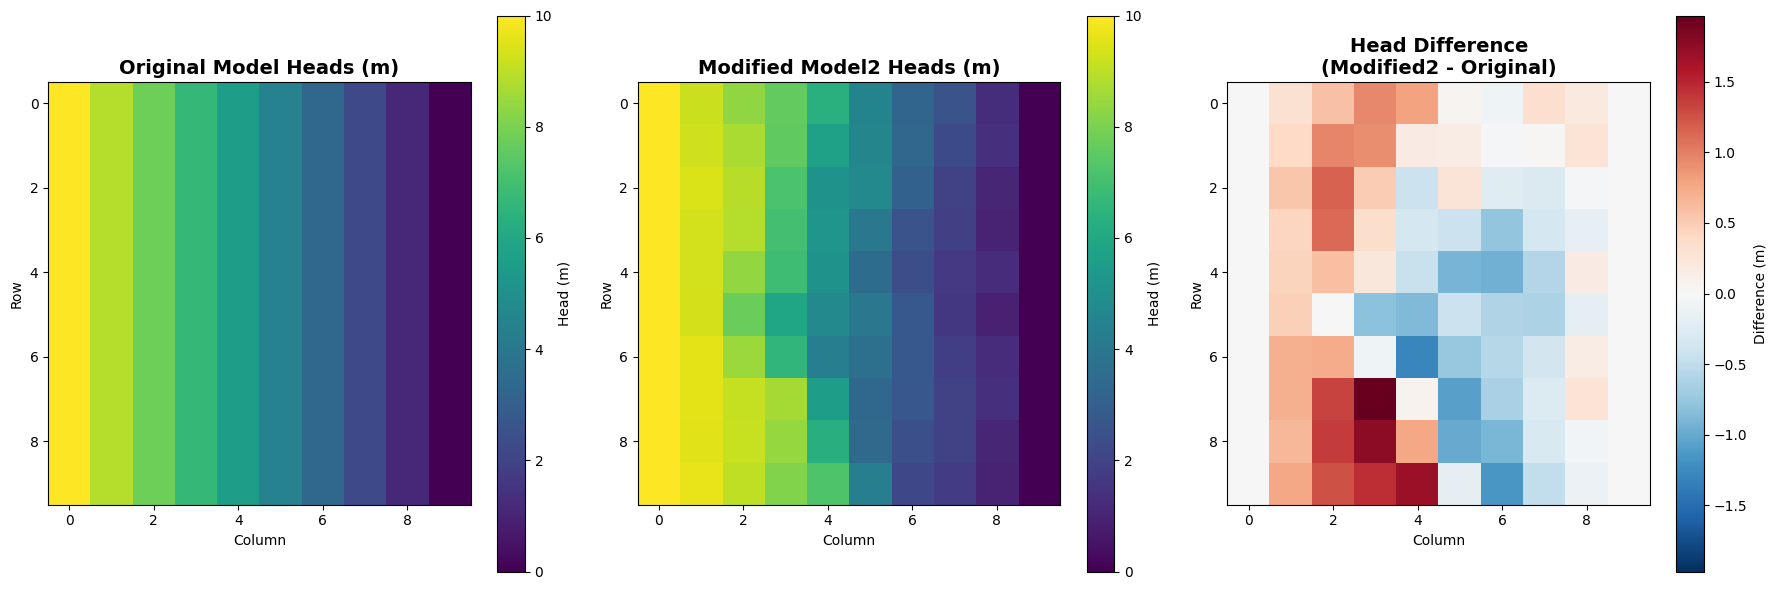

[[[ 0.         -0.25557804 -0.4944353  -0.78035355 -0.67661715
   -0.08527613  0.06291676 -0.22368169 -0.1208992   0.        ]
  [ 0.         -0.32244587 -0.76007175 -0.71742105 -0.12912226
   -0.16699505  0.02156973  0.02850485 -0.18037999  0.        ]
  [ 0.         -0.41721058 -0.94159985 -0.34090424  0.44307756
   -0.20814228  0.2615254   0.31013358  0.06535709  0.        ]
  [ 0.         -0.3370266  -0.8982706  -0.22047663  0.4241686
    0.49032307  0.83429     0.39156246  0.141626    0.        ]
  [ 0.         -0.3334961  -0.45256567 -0.09418106  0.5090542
    0.9247322   0.9222691   0.57013273 -0.0755012   0.        ]
  [ 0.         -0.3747034   0.07519627  0.81158495  0.86840963
    0.48583364  0.62789226  0.5971607   0.17733198  0.        ]
  [ 0.         -0.59869003 -0.6020608   0.11070585  1.2207112
    0.74286675  0.57753253  0.37291682 -0.06880689  0.        ]
  [ 0.         -0.6023636  -1.1627707  -1.7146335  -0.02761221
    0.92752266  0.62019825  0.29679477 -0.16493833 

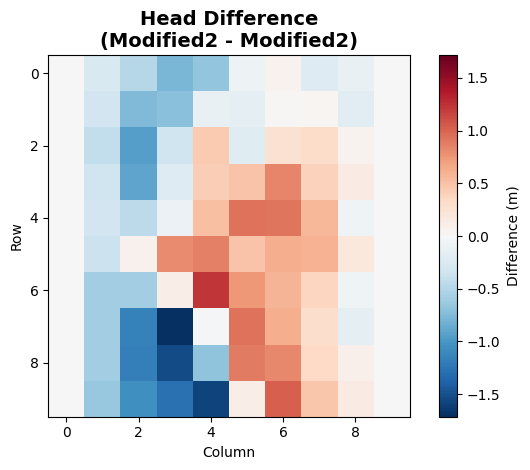

In [12]:
# Define file paths for both models
headfile_original = f'{original_ws}/{modelname}.hds'
headfile_modified2 = f'{model_ws_modified2}/{new_modelname2}.hds'

# Check if output files exist
if not os.path.exists(headfile_original):
    raise FileNotFoundError(f"Original model head file not found: {headfile_original}")

if not os.path.exists(headfile_modified2):
    raise FileNotFoundError(f"Modified model head file not found: {headfile_modified2}")

# Read heads from the original model
hds_original = flopy.utils.HeadFile(headfile_original)
head_original = hds_original.get_data()

# Read heads from the modified model
hds_modified = flopy.utils.HeadFile(headfile_modified2)
head_modified2 = hds_modified.get_data()

# Calculate head difference and plot results
head_diff = head_modified2 - head_original
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
cmap = mp.cm.viridis

# Original heads
im1 = axes[0].imshow(head_original[0, :, :], cmap=cmap)
axes[0].set_title('Original Model Heads (m)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Column')
axes[0].set_ylabel('Row')
plt.colorbar(im1, ax=axes[0], orientation='vertical', label='Head (m)')

# Modified heads
im2 = axes[1].imshow(head_modified2[0, :, :], cmap=cmap)
axes[1].set_title('Modified Model2 Heads (m)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Column')
axes[1].set_ylabel('Row')
plt.colorbar(im2, ax=axes[1], orientation='vertical', label='Head (m)')

# Head difference
im3 = axes[2].imshow(head_diff[0, :, :], cmap='RdBu_r', 
                     vmin=-np.max(np.abs(head_diff)), 
                     vmax=np.max(np.abs(head_diff)))
axes[2].set_title('Head Difference\n(Modified2 - Original)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Column')
axes[2].set_ylabel('Row')
plt.colorbar(im3, ax=axes[2], orientation='vertical', label='Difference (m)')

plt.tight_layout()
plt.show()

diff2 = head_modified-head_modified2
print(head_modified-head_modified2)

im4 = plt.imshow(diff2[0, :, :], cmap='RdBu_r', 
                     vmin=-np.max(np.abs(diff2)), 
                     vmax=np.max(np.abs(diff2)))
plt.title('Head Difference\n(Modified2 - Modified2)', fontsize=14, fontweight='bold')
plt.xlabel('Column')
plt.ylabel('Row')
plt.colorbar(im4, orientation='vertical', label='Difference (m)')

plt.tight_layout()
plt.show()